In [1]:
import pickle
import collections
from urllib.request import urlopen
from data_processing import *
import warnings
warnings.filterwarnings("ignore")

pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', 50)
pd.set_option('display.width', 500)
#%matplotlib inline
acc_round_val = 2
f1_round_val = 4
alpha = 0.01

# Set the task
task_name = 'maptask'
# Get Maptask metadata and training set
base_url = 'https://raw.github.com/NathanDuran/Maptask-Corpus/master/maptask_data/'
metadata = pickle.load(urlopen(base_url + 'metadata/metadata.pkl'))
text_data = [line.decode('utf-8').rstrip('\r\n') for line in urlopen(base_url + 'train_set.txt')]

c:\python\virtual environments\venv-tf-1.15\lib\site-packages\outdated\utils.py:18: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.3.12, the latest is 0.5.2.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs


# Vocabulary Size
The number of words to keep in the vocabulary during pre-processing.
Less frequent words were considered OOV and replaced with the <unk> token. Increments of 100 in the range [100, 1600].

Get the vocabulary size corresponding to max validation and test accuracy per model.

In [10]:
# Name of the experiment parameter for comparison
exp_param = 'vocab_size'

# Load vocabulary experiment data
vocab_data = load_dataframe(os.path.join(task_name, exp_param, exp_param + '_data.csv'))
vocab_mean_data = load_dataframe(os.path.join(task_name, exp_param, exp_param + '_mean_data.csv'))

# Get the max values for each model
print("Best validation accuracy in mean data:")
print(vocab_mean_data.loc[[vocab_mean_data['val_acc'].idxmax()], ['model_name', exp_param, 'val_acc', 'val_acc_std']])
print("Best test accuracy in mean data:")
print(vocab_mean_data.loc[[vocab_mean_data['test_acc'].idxmax()], ['model_name', exp_param, 'test_acc', 'test_acc_std', 'f1_weighted', 'f1_weighted_std', 'f1_weighted']]) ###TODO keep weighted?
vocab_data_max = get_max(vocab_mean_data, [exp_param])
vocab_data_max.round({'val_acc': acc_round_val, 'val_acc_std': acc_round_val, 'test_acc':acc_round_val, 'test_acc_std':acc_round_val, 'f1_weighted' :f1_round_val, 'f1_weighted_std' :f1_round_val})

Best validation accuracy in mean data:
   model_name  vocab_size    val_acc  val_acc_std
83        gru        1200  58.872602     0.237911
Best test accuracy in mean data:
   model_name  vocab_size   test_acc  test_acc_std  f1_weighted  f1_weighted_std  f1_weighted
87        gru         800  60.815372      0.828933     0.596317          0.00597     0.596317


,model_name,vocab_size,val_acc,val_acc_std,vocab_size,test_acc,test_acc_std,f1_weighted,f1_weighted_std
0,cnn,500,57.85,0.18,700,59.45,0.35,0.5735,0.0048
1,text cnn,200,56.60,0.33,1100,59.36,0.68,0.5719,0.0080
2,dcnn,600,56.08,0.32,500,59.24,0.45,0.5714,0.0055
3,rcnn,1100,58.28,0.20,800,60.28,0.44,0.5867,0.0036
4,lstm,800,55.88,0.38,900,60.37,0.52,0.5841,0.0052
5,gru,1200,58.87,0.24,800,60.82,0.83,0.5963,0.0060


Plot accuracy of each model per vocabulary size.

Vertical lines are the mean frequency of word occurrence within a given range
i.e. the 200-300 most frequent words appear, on average, ~71 times.

    vocab_size    mean_freq   cum_sum
0        100.0  1268.712871  128140.0
1        200.0   162.356436  144259.0
2        300.0    71.693069  151403.0
3        400.0    45.188119  155911.0
4        500.0    28.287129  158733.0
5        600.0    19.000000  160629.0
6        700.0    12.326733  161859.0
7        800.0     7.752475  162632.0
8        900.0     5.128713  163144.0
9       1000.0     3.415842  163485.0
10      1100.0     2.554455  163740.0
11      1200.0     2.000000  163940.0
12      1300.0     1.267327  164066.0
13      1400.0     1.000000  164166.0
14      1500.0     1.000000  164266.0
15      1600.0     1.000000  164365.0
Total word count: 164562
Percentage of words for vocabulary size 400: 94.74


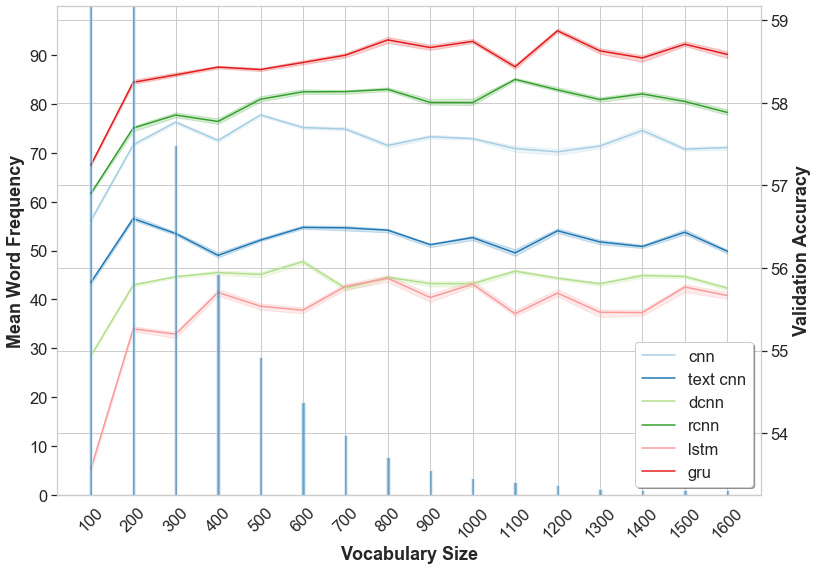

In [3]:
# Get word frequencies from metadata and bin/sum into same values as experiment
word_freq = metadata['word_freq'].iloc[:1600]
words_frame = pd.DataFrame(columns=['vocab_size', 'mean_freq', 'cum_sum'])
ind_start, ind_end = 0, 100
for i in range(16):
    words_frame = words_frame.append({'vocab_size': ind_end,
                                      'mean_freq': float(word_freq.loc[ind_start:ind_end].mean()), # Binning
                                      'cum_sum': word_freq.loc[0:ind_end].sum()['Count']}, # Cumulative summing
                                     ignore_index=True)
    ind_start += 100
    ind_end += 100
print(words_frame)

# Calculate percentage of words up to specified vocabulary size
vocab_size = 400
total_words = metadata['word_freq']['Count'].sum()
word_cum_sum = float(words_frame.loc[(words_frame['vocab_size'] == vocab_size)]['cum_sum'])
perc_of_total = (100 / total_words) * word_cum_sum
print("Total word count: " + str(total_words))
print("Percentage of words for vocabulary size " + str(vocab_size) + ": " + str(round(perc_of_total, 2)))

# Get experiment validation accuracy data for each model
vocab_acc_data = vocab_data.drop(vocab_data.columns.difference(['model_name', exp_param, 'val_acc']), axis=1)
vocab_acc_data = vocab_acc_data.rename(columns={'val_acc': 'Val Acc'})
vocab_acc_data = vocab_acc_data.melt(id_vars=['model_name', exp_param])

# Plot line/bar chart
fig = plot_line_bar_chart(vocab_acc_data, words_frame, x=exp_param, y='value', hue='model_name',
                          title='', y_label='Validation Accuracy', x_label='Vocabulary Size', colour='Paired',
                          bar_x=exp_param, bar_y='mean_freq', bar_axis_step=10, bar_axis_range=[0, 100], bar_width=8,
                          bar_y_label='Mean Word Frequency', bar_alpha=0.5, bar_color='tab:blue',
                          legend_loc='lower right', num_legend_col=1, xtick_rotation=45)
fig.savefig(os.path.join(task_name, exp_param, exp_param + '_accuracy.png'))

Test RM ANOVA assumptions using Shapiro-Wilks test for normality and Mauchly test for sphericity.

Perform RM ANOVA for each model, comparing different vocabulary size groups.

In [4]:
# Set the metric to test
metric = 'val_acc'

# Run Shaprio-wilks test for normal distribution
shapiro_wilk_test(vocab_data, exp_param, metric)

# Run ANOVA
vocab_aov = rm_one_way_anova_test(vocab_data, exp_param, metric, sig_level=alpha)
vocab_aov.round(5)

All models vocab_size are normally distributed.
All models have significant p-values when comparing vocab_size groups.


,Source,SS,DF,MS,F,p-unc,p-GG-corr,np2,eps,sphericity,W-spher,p-spher,cohen_f,n,exp_n,power,exp_power
cnn,vocab_size,11.8871,15,0.792476,11.6126,7.76763e-18,1.97189e-07,0.563375,0.345418,True,2.12051e+07,1,1.08256,160,40.4152,1,0.8
text cnn,vocab_size,5.06137,15,0.337425,3.97781,6.34316e-06,0.00329995,0.306509,0.363863,True,4.65693e+06,1,0.366054,160,85.4975,0.997748,0.8
dcnn,vocab_size,9.31015,15,0.620677,8.45386,2.25238e-13,8.12315e-06,0.484355,0.343131,True,1.42418e+07,1,0.79481,160,48.6224,1,0.8
rcnn,vocab_size,15.3206,15,1.02137,10.7211,1.22606e-16,9.02335e-08,0.543637,0.396716,True,4.10056e+06,1,1.00737,160,42.0975,1,0.8
lstm,vocab_size,43.9016,15,2.92677,15.647,9.52311e-23,1.24117e-09,0.634844,0.367739,True,19202.6,1,1.4,160,35.3467,1,0.8
gru,vocab_size,20.4758,15,1.36505,14.7315,1.06324e-21,5.77032e-09,0.620757,0.353914,True,1.0567e+06,1,1.37757,160,35.6264,1,0.8


Tukey Honest Significant Difference Post-Hoc analysis for pairwise comparison of groups.

Heatmaps shows Tukey-HSD results for each model.

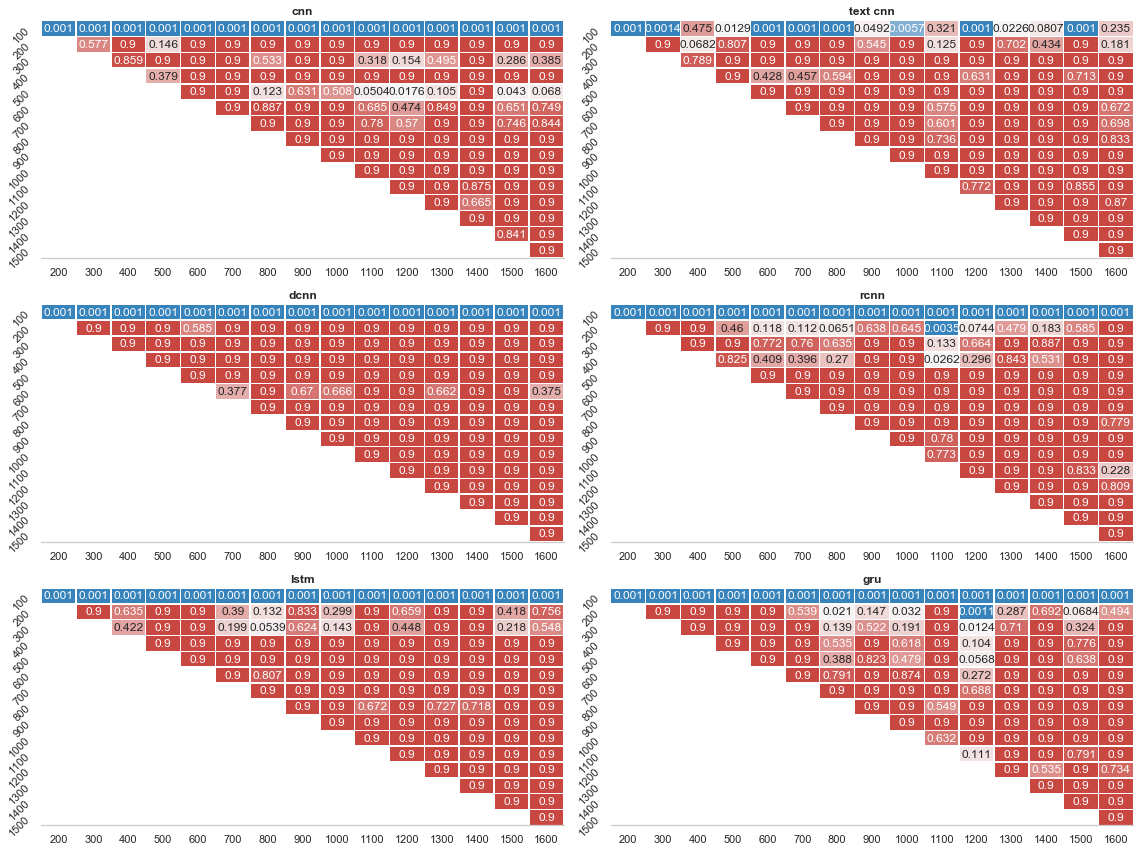

In [5]:
# Run Tukey-HSD post-hoc analysis
tukey_frame = tukey_hsd(vocab_data, exp_param, metric, show_result=False)

# Generate heatmaps
g, fig = plot_facetgrid(tukey_frame, x='group1', y='group2', hue='p-value', col='model_name', kind='heatmap',
                        title='', y_label='', x_label='', num_col=2, colour='RdBu_r',
                        annot=True, fmt='0.3', linewidths=0.5, cbar=False, custom_boundaries=[0.0, alpha, 1.0],
                        y_tick_rotation=45, height=4)

Multiple Pairwise Bayes sign rank

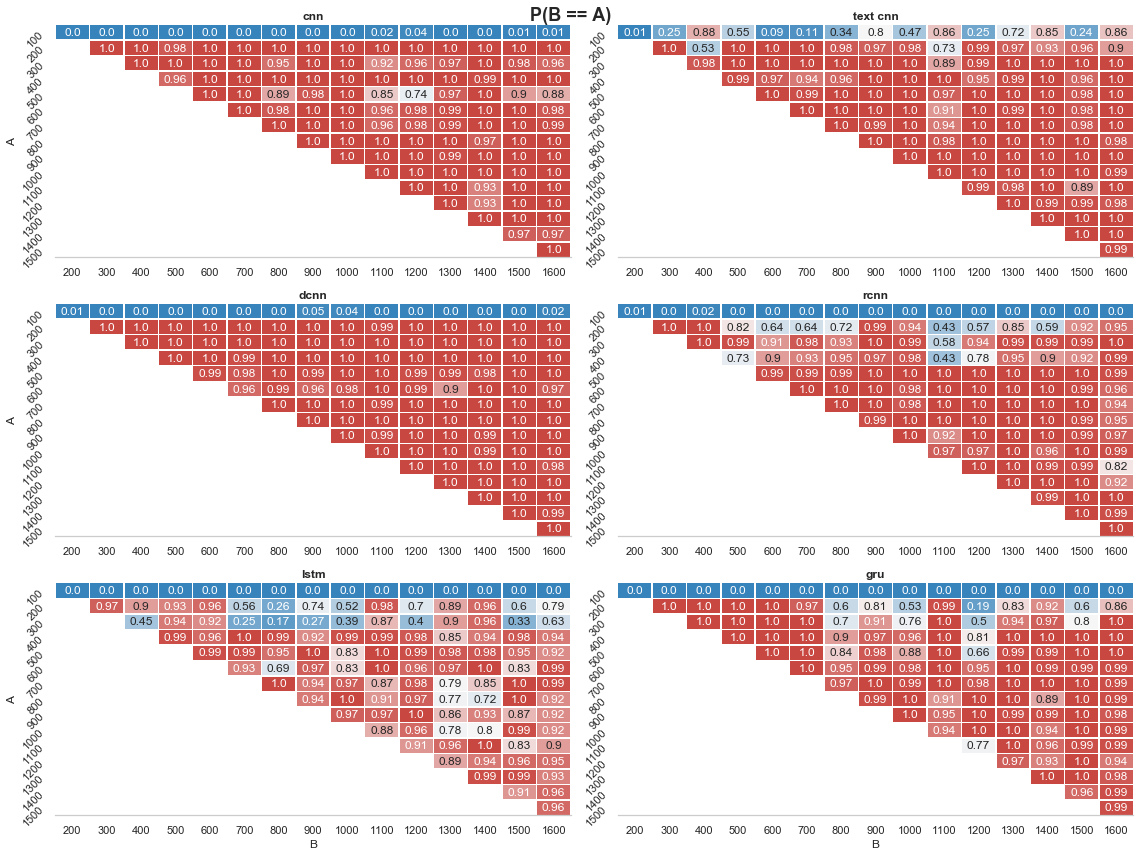

In [12]:
# Set the metric to test
metric = 'val_acc'

# Multi-pairwise Bayes takes a long time to calculate, so save/load as needed
# bayes_vocab_frame = multi_pairwise_bayes_signrank(vocab_data, 'model_name', exp_param, metric, rope=0.5)
# save_dataframe(os.path.join(task_name, exp_param, exp_param + '_bayes_results.csv'), bayes_vocab_frame)
bayes_vocab_frame = load_dataframe(os.path.join(task_name, exp_param, exp_param + '_bayes_results.csv'))

# Generate heatmaps
g, fig = plot_facetgrid(bayes_vocab_frame.round(2), x='model_A', y='model_B', hue='within', col='model_name', kind='heatmap',
                        title='P(B == A)', y_label='A', x_label='B', num_col=2, colour='RdBu_r',
                        annot=True, fmt='0.2', linewidths=0.5, cbar=False, custom_boundaries=[0.0, 0.8, 1.0],
                        y_tick_rotation=45, height=4)
# bayes_vocab_frame.round(3)

# Sequence Length
The number of tokens in the input sequence. Sentences are padded, with a <pad> token, or truncated to this length.
Increments of 5 in the range [5, 50].

Get the sequence length corresponding to max validation and test accuracy per model.

In [13]:
# Name of the experiment parameter for comparison
exp_param = 'max_seq_length'

# Load sequence length experiment data
seq_data = load_dataframe(os.path.join(task_name, exp_param, exp_param + '_data.csv'))
seq_mean_data = load_dataframe(os.path.join(task_name, exp_param, exp_param + '_mean_data.csv'))

# Get the max values for each model
print("Best validation accuracy in mean data:")
print(seq_mean_data.loc[[seq_mean_data['val_acc'].idxmax()], ['model_name', exp_param, 'val_acc', 'val_acc_std']])
print("Best test accuracy in mean data:")
print(seq_mean_data.loc[[seq_mean_data['test_acc'].idxmax()], ['model_name', exp_param, 'test_acc', 'test_acc_std', 'f1_weighted', 'f1_weighted_std']])
seq_data_max = get_max(seq_mean_data, [exp_param])
seq_data_max.round({'val_acc': acc_round_val, 'val_acc_std': acc_round_val, 'test_acc':acc_round_val, 'test_acc_std':acc_round_val, 'f1_weighted' :f1_round_val, 'f1_weighted_std' :f1_round_val})

Best validation accuracy in mean data:
   model_name  max_seq_length    val_acc  val_acc_std
53        gru              30  58.677818     0.254389
Best test accuracy in mean data:
   model_name  max_seq_length   test_acc  test_acc_std  f1_weighted  f1_weighted_std
54        gru              25  60.872844      0.415885     0.596122         0.004122


,model_name,max_seq_length,val_acc,val_acc_std,max_seq_length,test_acc,test_acc_std,f1_weighted,f1_weighted_std
0,cnn,25,57.49,0.26,35,59.48,0.51,0.5751,0.0048
1,text cnn,40,56.40,0.33,15,59.27,0.46,0.5771,0.0073
2,dcnn,25,56.14,0.24,20,59.28,0.44,0.5733,0.0049
3,rcnn,25,58.13,0.26,25,60.21,0.64,0.5872,0.0067
4,lstm,10,57.98,0.26,50,60.18,0.66,0.5885,0.0057
5,gru,30,58.68,0.25,25,60.87,0.42,0.5961,0.0041


Plot accuracy of each model per sequence length.

Vertical lines are the cumulative frequency of utterances up to a given sequence length
i.e. there are 17550 sentences in the test set of length <= 10.

   max_seq_length    mean_freq  cum_sum
0             5.0  2663.600000  13318.0
1            10.0   932.000000  17550.0
2            15.0   414.833333  19494.0
3            20.0   182.166667  20324.0
4            25.0    83.833333  20712.0
5            30.0    39.000000  20881.0
6            35.0    18.833333  20971.0
7            40.0     8.833333  21010.0
8            45.0     4.000000  21028.0
9            50.0     3.200000  21041.0
Total sentence count: 21052
Percentage of sentences for sequence length 15: 92.6


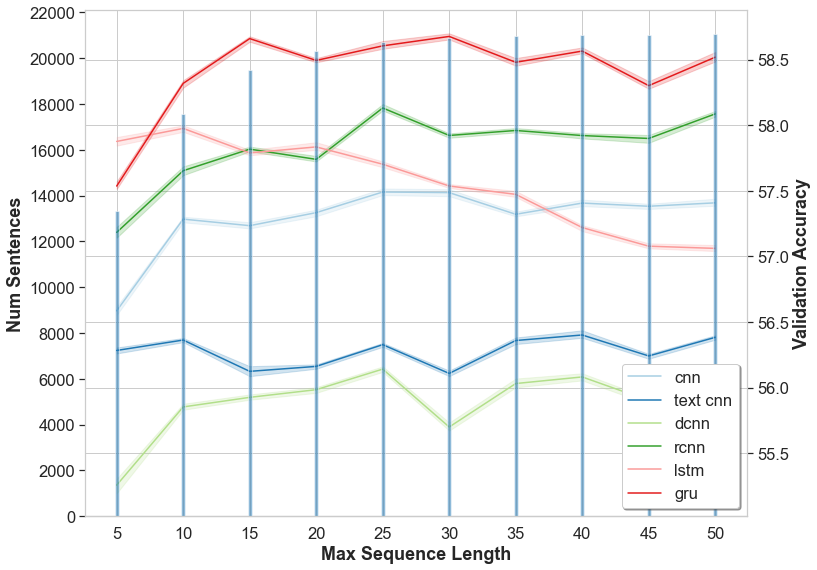

In [17]:
# Get text data from training set and count sequence lengths
sentences = [line.split('|')[1] for line in text_data]
sent_lengths = [len(sent.split(' ')) for sent in sentences]
sent_len_count = collections.Counter(sent_lengths)
sent_len_count = pd.DataFrame.from_dict(dict(sorted(sent_len_count.items())), orient='index')

# Get word sentence lengths and bin/sum into same values as experiment
sents_frame = pd.DataFrame(columns=['max_seq_length', 'mean_freq', 'cum_sum'])
ind_start, ind_end = 0, 5
for i in range(10):
    sents_frame = sents_frame.append({'max_seq_length': ind_end,
                                      'mean_freq': float(sent_len_count.loc[ind_start:ind_end].mean()), # Binning
                                      'cum_sum': float(sent_len_count.loc[0:ind_end].sum())}, # Cumulative summing
                                     ignore_index=True)
    ind_start += 5
    ind_end += 5
print(sents_frame)

# Calculate percentage of sentences up to specified max length
seq_len = 15
total_sent = int(sent_len_count.sum())
sent_cum_sum = float(sents_frame.loc[(sents_frame['max_seq_length'] == seq_len)]['cum_sum'])
perc_of_total = (100 / total_sent) * sent_cum_sum
print("Total sentence count: " + str(total_sent))
print("Percentage of sentences for sequence length " + str(seq_len) + ": " + str(round(perc_of_total, 2)))

# Get experiment validation accuracy data for each model
seq_acc_data = seq_data.drop(seq_data.columns.difference(['model_name', exp_param, 'val_acc']), axis=1)
seq_acc_data = seq_acc_data.rename(columns={'val_acc': 'Val Acc'})
seq_acc_data = seq_acc_data.melt(id_vars=['model_name', exp_param])

# Plot line/bar chart
fig = plot_line_bar_chart(seq_acc_data, sents_frame, x=exp_param, y='value', hue='model_name',
                          title='', y_label='Validation Accuracy', x_label='Max Sequence Length', colour='Paired',
                          bar_x=exp_param, bar_y='cum_sum', bar_axis_step=2000, bar_axis_range=None, bar_width=0.3,
                          bar_y_label='Num Sentences', bar_alpha=0.5, bar_color='tab:blue',
                          legend_loc='lower right', num_legend_col=1)
fig.savefig(os.path.join(task_name, exp_param, exp_param + '_accuracy.png'))

Test RM ANOVA assumptions using Shapiro-Wilks test for normality and Mauchly test for sphericity.

Perform RM ANOVA for each model, comparing different sequence length groups.

In [4]:
# Set the metric to test
metric = 'val_acc'

# Run Shaprio-wilks test for normal distribution
shapiro_wilk_test(seq_data, exp_param, metric)

# Run ANOVA
seq_aov = rm_one_way_anova_test(seq_data, exp_param, metric, sig_level=alpha)
seq_aov.round(5)

The following max_seq_length are not normally distributed.
  model_name max_seq_length    t-stat   p-value
3        cnn             20  0.829943  0.033408
The following models do not have significant p-values when comparing max_seq_length groups.
                  Source       SS DF        MS        F      p-unc p-GG-corr       np2      eps sphericity    W-spher  p-spher   cohen_f    n    exp_n     power exp_power
text cnn  max_seq_length  1.09859  9  0.122065  1.79671  0.0814149  0.154797  0.166412  0.42239       True  0.0360107  1.00013  0.169959  100  137.128  0.570394       0.8


,Source,SS,DF,MS,F,p-unc,p-GG-corr,np2,eps,sphericity,W-spher,p-spher,cohen_f,n,exp_n,power,exp_power
cnn,max_seq_length,6.17918,9,0.686576,9.83623,4.99157e-10,1.87792e-06,0.522197,0.561755,True,0.00288032,0.979169,0.882753,100,35.9454,0.999999,0.8
text cnn,max_seq_length,1.09859,9,0.122065,1.79671,0.0814149,0.154797,0.166412,0.42239,True,0.0360107,1.00013,0.169959,100,137.128,0.570394,0.8
dcnn,max_seq_length,5.68724,9,0.631915,6.4071,8.03994e-07,0.00112668,0.415854,0.381884,True,0.215612,1,0.598919,100,47.2471,0.999546,0.8
rcnn,max_seq_length,6.53394,9,0.725993,9.20784,1.7726e-09,2.68001e-05,0.505707,0.453206,True,0.225306,1,0.846577,100,36.9597,0.999998,0.8
lstm,max_seq_length,10.2638,9,1.14042,16.5796,4.269e-15,6.92028e-08,0.648157,0.451735,True,0.12001,1,1.4,100,27.2416,1,0.8
gru,max_seq_length,10.0298,9,1.11443,13.1339,1.11247e-12,1.52873e-06,0.593383,0.430557,True,0.000100995,0.342342,1.16959,100,30.1528,1,0.8


Tukey Honest Significant Difference Post-Hoc analysis for pairwise comparison of groups.

Heatmaps shows Tukey-HSD results for each model.

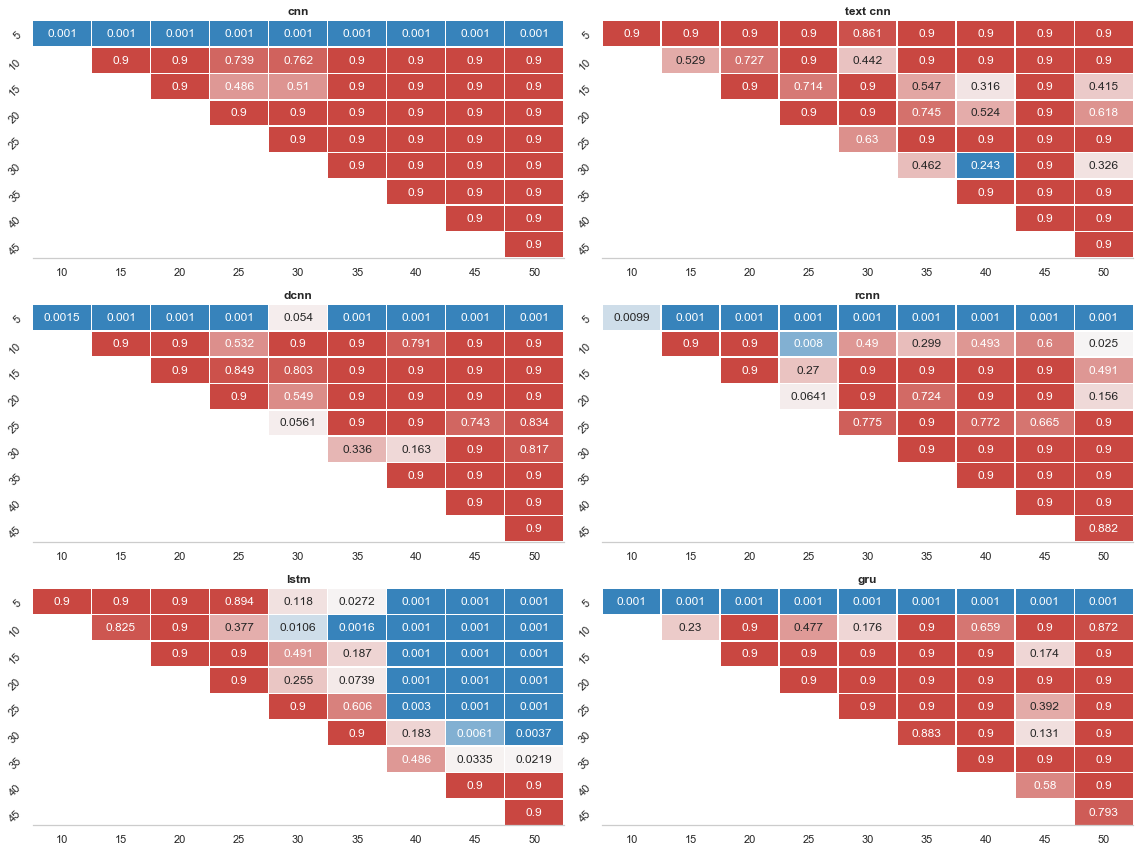

In [10]:
# Run Tukey-HSD post-hoc analysis
tukey_frame = tukey_hsd(seq_data, exp_param, metric, show_result=False)

# Generate heatmaps
g, fig = plot_facetgrid(tukey_frame, x='group1', y='group2', hue='p-value', col='model_name', kind='heatmap',
                        title='', y_label='', x_label='', num_col=2, colour='RdBu_r',
                        annot=True, fmt='0.3', linewidths=0.5, cbar=False, custom_boundaries=[0.0, alpha, 1.0],
                        y_tick_rotation=45, height=4)

Multiple Pairwise Bayes sign rank

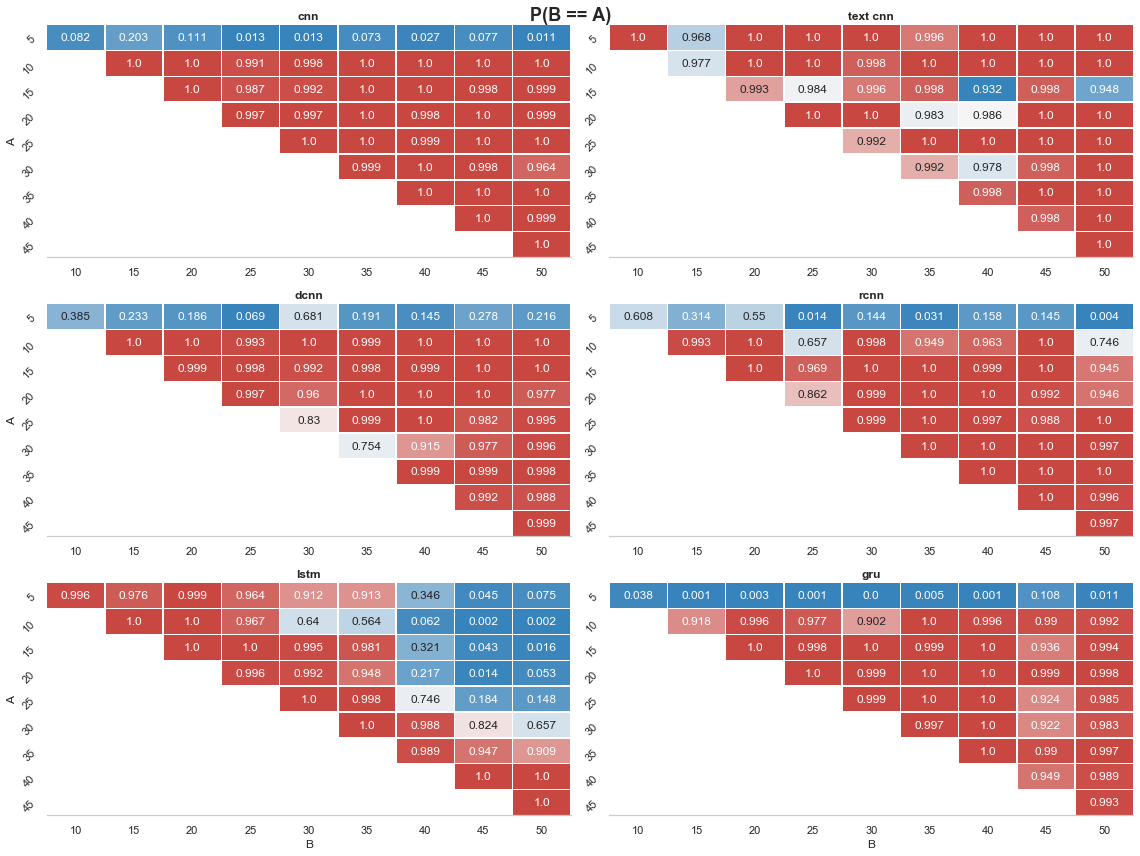

In [18]:
# Set the metric to test
metric = 'val_acc'

# Multi-pairwise Bayes takes a long time to calculate, so save/load as needed
# bayes_seq_frame = multi_pairwise_bayes_signrank(seq_data, 'model_name', exp_param, metric, rope=0.5)
# save_dataframe(os.path.join(task_name, exp_param, exp_param + '_bayes_results.csv'), bayes_seq_frame)
bayes_seq_frame = load_dataframe(os.path.join(task_name, exp_param, exp_param + '_bayes_results.csv'))

# Generate heatmaps
g, fig = plot_facetgrid(bayes_seq_frame.round(3), x='model_A', y='model_B', hue='within', col='model_name', kind='heatmap',
                        title='P(B == A)', y_label='A', x_label='B', num_col=2, colour='RdBu_r',
                        annot=True, fmt='0.3', linewidths=0.5, cbar=False, custom_boundaries=[0.0, 0.8, 1.0],
                        y_tick_rotation=45, height=4)
# bayes_seq_frame.round(3)

# Input Sequence Comparison

Compare a combination of vocabulary sizes (400, 800 or 1.7k words) and sequence lengths (25, 50 or 115 tokens)
in small, medium and large groups.

In [19]:
# Name of the experiment parameters for comparison
exp_params = ['vocab_size', 'max_seq_length']
# Load experiment data
inseq_data = load_dataframe(os.path.join(task_name, 'input_seq', 'input_seq_data.csv'))
inseq_mean_data = load_dataframe(os.path.join(task_name, 'input_seq', 'input_seq_mean_data.csv'))


# Get the max values for each model
print("Best validation accuracy in mean data:")
print(inseq_mean_data.loc[[inseq_mean_data['val_acc'].idxmax()], ['model_name'] + exp_params + ['val_acc', 'val_acc_std']])
print("Best test accuracy in mean data:")
print(inseq_mean_data.loc[[inseq_mean_data['test_acc'].idxmax()], ['model_name'] + exp_params + ['test_acc', 'test_acc_std', 'f1_weighted', 'f1_weighted_std']])
inseq_data_max = get_max(inseq_mean_data, exp_params)
inseq_data_max.round({'val_acc': acc_round_val, 'val_acc_std': acc_round_val, 'test_acc':acc_round_val, 'test_acc_std':acc_round_val, 'f1_weighted' :f1_round_val, 'f1_weighted_std' :f1_round_val})

Best validation accuracy in mean data:
   model_name  vocab_size  max_seq_length    val_acc  val_acc_std
16        gru         800              50  58.587316     0.314054
Best test accuracy in mean data:
   model_name  vocab_size  max_seq_length  test_acc  test_acc_std  f1_weighted  f1_weighted_std
16        gru         800              50  60.67816      0.520228       0.5929          0.00607


,model_name,vocab_size,max_seq_length,val_acc,val_acc_std,vocab_size,max_seq_length,test_acc,test_acc_std,f1_weighted,f1_weighted_std
0,cnn,400,25,57.72,0.23,1700,115,59.29,0.53,0.5736,0.0053
1,text cnn,1700,115,56.33,0.28,800,50,59.20,0.41,0.5702,0.0057
2,dcnn,800,50,56.11,0.26,1700,115,58.86,0.54,0.5682,0.0073
3,rcnn,1700,115,58.05,0.23,1700,115,59.85,0.57,0.5861,0.0048
4,lstm,400,25,57.47,0.25,800,50,59.90,0.78,0.5882,0.0075
5,gru,800,50,58.59,0.31,800,50,60.68,0.52,0.5929,0.0061


Test RM ANOVA assumptions using Shapiro-Wilks test for normality and Mauchly test for sphericity.

Perform RM ANOVA comparing vocabulary size (400, 800 or 1.7k words) and sequence lengths (25, 50 or 115 tokens) for each model.

In [13]:
# Add column to identify each combination
inseq_data = inseq_data.drop(inseq_data.columns.difference(['model_name', 'val_acc', 'vocab_size', 'max_seq_length']), axis=1)
conditions = [(inseq_data['vocab_size'] == 400) & (inseq_data['max_seq_length'] == 25),
              (inseq_data['vocab_size'] == 800) & (inseq_data['max_seq_length'] == 50),
              (inseq_data['vocab_size'] == 1700) & (inseq_data['max_seq_length'] == 115)]
choices = ['V=400_S=25', 'V=800_S=50', 'V=1.7k_S=115']
inseq_data['exp_params'] = np.select(conditions, choices)
inseq_data.drop(inseq_data[inseq_data.exp_params == '0'].index, inplace=True)

# Set the metric to test and new exp_param column
metric = 'val_acc'
exp_param = 'exp_params'

# Run Shaprio-wilks test for normal distribution
shapiro_wilk_test(inseq_data, exp_param, metric)

# Run ANOVA
seq_aov = rm_one_way_anova_test(inseq_data, exp_param, metric, sig_level=alpha)
seq_aov.round(5)

All models exp_params are normally distributed.
The following models do not have significant p-values when comparing exp_params groups.
              Source         SS DF         MS         F      p-unc  p-GG-corr       np2       eps sphericity   W-spher    p-spher    cohen_f   n    exp_n     power exp_power
text cnn  exp_params  0.0394172  2  0.0197086  0.442841   0.649021   0.646332  0.046897  0.985623       True  0.985413   0.942918  0.0246367  30  568.032  0.027308       0.8
dcnn      exp_params    0.54854  2    0.27427   4.68767   0.022973   0.041744  0.342474  0.679992       True  0.529394  0.0785447    0.27239  30  55.6933  0.408444       0.8
rcnn      exp_params   0.329553  2   0.164776   3.38325  0.0565809  0.0633793  0.273212  0.898933       True   0.88757   0.620597   0.198558  30  74.6093  0.274696       0.8
gru       exp_params   0.395336  2   0.197668   2.42063   0.117212   0.123433  0.211952  0.909977       True  0.901071   0.659229   0.161345  30  90.7156  0.209413     

,Source,SS,DF,MS,F,p-unc,p-GG-corr,np2,eps,sphericity,W-spher,p-spher,cohen_f,n,exp_n,power,exp_power
cnn,exp_params,0.538149,2,0.269074,10.2864,0.00104933,0.00166826,0.533351,0.898979,True,0.887628,0.620759,0.285519,30,53.3556,0.431914,0.8
text cnn,exp_params,0.0394172,2,0.0197086,0.442841,0.649021,0.646332,0.046897,0.985623,True,0.985413,0.942918,0.0246367,30,568.032,0.027308,0.8
dcnn,exp_params,0.54854,2,0.27427,4.68767,0.022973,0.041744,0.342474,0.679992,True,0.529394,0.0785447,0.27239,30,55.6933,0.408444,0.8
rcnn,exp_params,0.329553,2,0.164776,3.38325,0.0565809,0.0633793,0.273212,0.898933,True,0.88757,0.620597,0.198558,30,74.6093,0.274696,0.8
lstm,exp_params,16.3282,2,8.16412,118.653,4.30425e-11,3.21172e-08,0.929496,0.687527,True,0.545513,0.0885562,1.4,30,14.976,0.998634,0.8
gru,exp_params,0.395336,2,0.197668,2.42063,0.117212,0.123433,0.211952,0.909977,True,0.901071,0.659229,0.161345,30,90.7156,0.209413,0.8


Tukey Honest Significant Difference Post-Hoc analysis for pairwise comparison of groups.

Heatmaps shows Tukey-HSD results for each model.

,model_name,vocab_size,max_seq_length,val_acc,val_acc_std
0,cnn,400,25,57.715008,0.229754
1,cnn,800,50,57.435096,0.245091
2,cnn,1700,115,57.426866,0.274998
3,text cnn,400,25,56.242147,0.221423
4,text cnn,800,50,56.301943,0.185893
5,text cnn,1700,115,56.328886,0.276422
6,dcnn,800,50,56.105340,0.263390
7,dcnn,400,25,55.974042,0.226531
8,dcnn,1700,115,55.776344,0.284061
9,rcnn,400,25,57.794118,0.251065


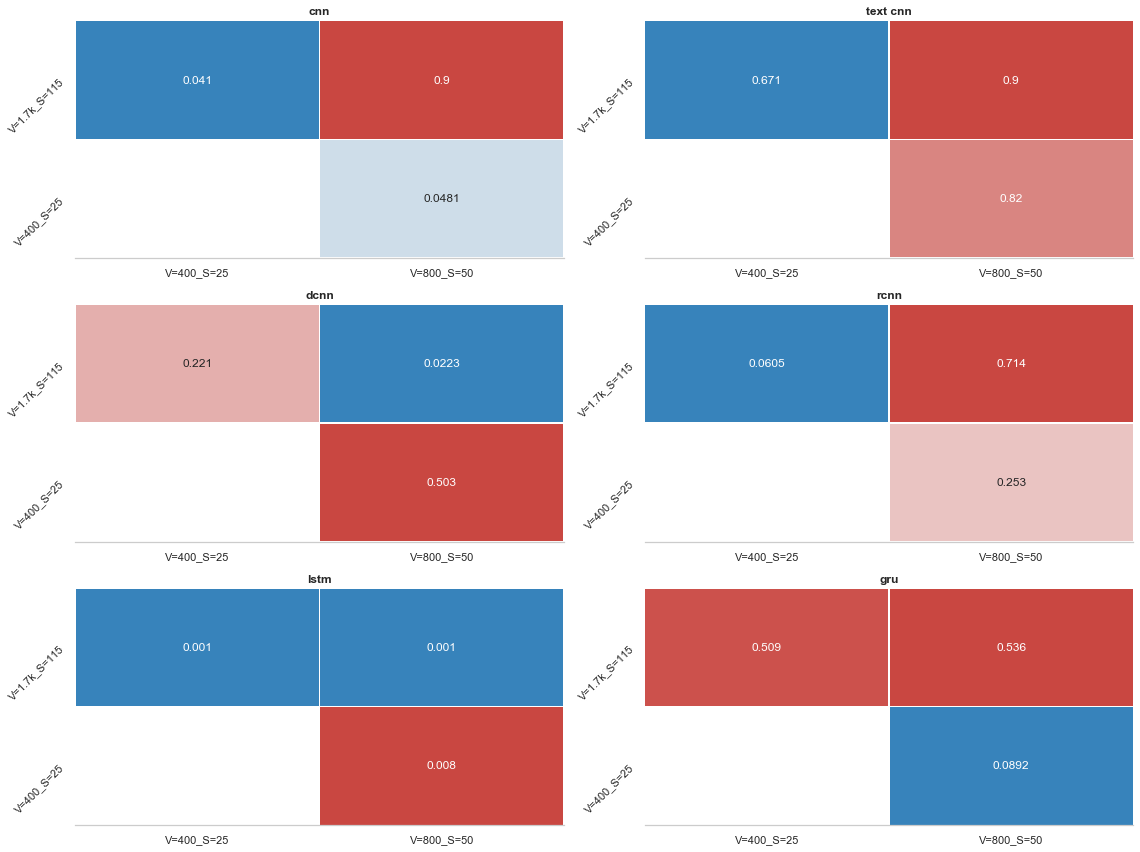

In [14]:
# Run Tukey-HSD post-hoc analysis
tukey_frame = tukey_hsd(inseq_data, exp_param, metric, show_result=False)

# Generate heatmaps
g, fig = plot_facetgrid(tukey_frame, x='group1', y='group2', hue='p-value', col='model_name', kind='heatmap',
                        title='', y_label='', x_label='', num_col=2, colour='RdBu_r',
                        annot=True, fmt='0.3', linewidths=0.5, cbar=False, custom_boundaries=[0.0, alpha, 1.0],
                        y_tick_rotation=45, height=4)

# Show results for each group
inseq_mean_data = inseq_mean_data.drop(inseq_mean_data.columns.difference(['model_name', 'val_acc', 'val_acc_std', 'vocab_size', 'max_seq_length']), axis=1)
inseq_mean_data

Pairwise Bayes sign rank

,model_name,model_A,model_B,P({a} > {b}),P({a} == {b}),P({b} > {a}),left,within,right
0,cnn,50,25,0.000,1.000,0.000,0.000,1.000,0.000
1,cnn,115,25,0.000,1.000,0.000,0.000,1.000,0.000
2,cnn,115,50,0.000,1.000,0.000,0.000,1.000,0.000
3,text cnn,50,25,0.000,1.000,0.000,0.000,1.000,0.000
4,text cnn,115,25,0.000,1.000,0.000,0.000,1.000,0.000
5,text cnn,115,50,0.000,1.000,0.000,0.000,1.000,0.000
6,dcnn,50,25,0.000,1.000,0.000,0.000,1.000,0.000
7,dcnn,115,25,0.000,1.000,0.000,0.000,1.000,0.000
8,dcnn,115,50,0.000,0.918,0.082,0.000,0.918,0.082
9,rcnn,50,25,0.002,0.998,0.000,0.002,0.998,0.000


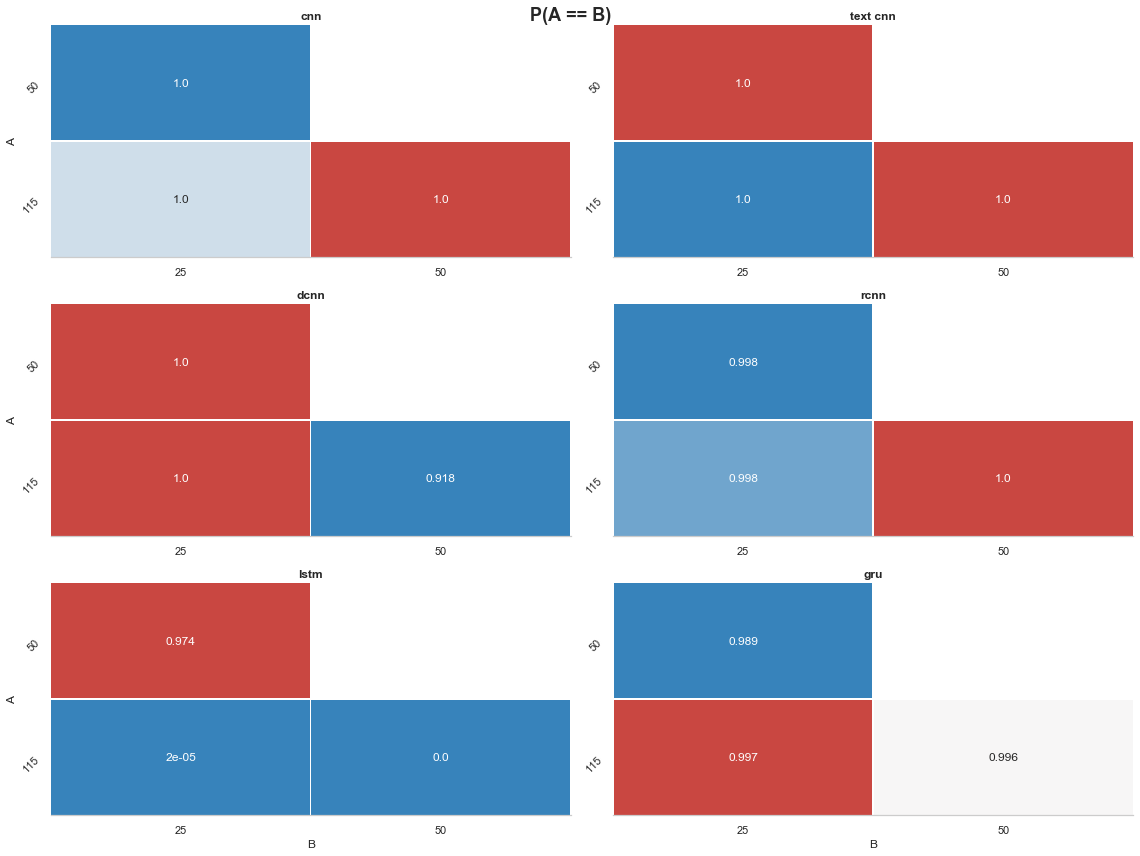

In [20]:
# Set the metric to test
metric = 'val_acc'

# Multi-pairwise Bayes
inseq_bayes = multi_pairwise_bayes_signrank(inseq_data, 'model_name', exp_param, metric, rope=0.5)

# Generate heatmaps
g, fig = plot_facetgrid(inseq_bayes, x='model_A', y='model_B', hue='within', col='model_name', kind='heatmap',
                        title='P(A == B)', y_label='A', x_label='B', num_col=2, colour='RdBu_r',
                        annot=True, fmt='0.3', linewidths=0.5, cbar=False, custom_boundaries=[0.0, 0.8, 1.0],
                        y_tick_rotation=45, height=4)
inseq_bayes.round(3)

# Word Vectors

Compare different dimensions of Word2Vec, GloVe, Fasttext, Numberbatch and Dependency for each model.
Dimension increments of 50 in the range [100, 300].

Get the embedding type and dimension corresponding to max validation and test accuracy per model.

In [27]:
# Name of the experiment parameter for comparison
exp_params = ['embedding_type', 'embedding_dim']

# Load language models experiment data
embed_data = load_dataframe(os.path.join(task_name, 'embedding_type', 'embedding_type_data.csv'))
embed_mean_data = load_dataframe(os.path.join(task_name,  'embedding_type', 'embedding_type_mean_data.csv'))

# Remove random embeddings because they are strictly worse
embed_data = embed_data.drop(embed_data[embed_data['embedding_type'] == 'random'].index)
embed_mean_data = embed_mean_data.drop(embed_mean_data[embed_mean_data['embedding_type'] == 'random'].index)

# Get the max values for each model
print("Best validation accuracy in mean data:")
print(embed_mean_data.loc[[embed_mean_data['val_acc'].idxmax()], ['model_name'] + exp_params + ['val_acc', 'val_acc_std']])
print("Best test accuracy in mean data:")
print(embed_mean_data.loc[[embed_mean_data['test_acc'].idxmax()], ['model_name'] + exp_params + ['test_acc', 'test_acc_std', 'f1_weighted', 'f1_weighted_std']])
embed_data_max = get_max(embed_mean_data, exp_params)
embed_data_max.round({'val_acc': acc_round_val, 'val_acc_std': acc_round_val, 'test_acc':acc_round_val, 'test_acc_std':acc_round_val, 'f1_weighted' :f1_round_val, 'f1_weighted_std' :f1_round_val})

Best validation accuracy in mean data:
    model_name embedding_type  embedding_dim    val_acc  val_acc_std
128        gru           deps            200  59.462143      0.23394
Best test accuracy in mean data:
   model_name embedding_type  embedding_dim  test_acc  test_acc_std  f1_weighted  f1_weighted_std
49   text cnn       word2vec            300   61.7227      0.411471     0.600852          0.00373


,model_name,embedding_type,embedding_dim,val_acc,val_acc_std,embedding_type,embedding_dim,test_acc,test_acc_std,f1_weighted,f1_weighted_std
0,cnn,fasttext,300,57.88,0.20,fasttext,150,59.53,0.74,0.5745,0.0090
1,text cnn,fasttext,300,58.97,0.24,word2vec,300,61.72,0.41,0.6009,0.0037
2,dcnn,fasttext,250,57.37,0.31,numberbatch,300,59.71,0.65,0.5792,0.0061
3,rcnn,deps,100,59.45,0.24,word2vec,200,61.01,0.44,0.5972,0.0058
4,lstm,glove,300,57.93,0.28,glove,300,60.41,0.58,0.5914,0.0044
5,gru,deps,200,59.46,0.23,numberbatch,200,61.62,0.49,0.6024,0.0038


Heatmap plot of accuracy of each model per embedding type and dimension.

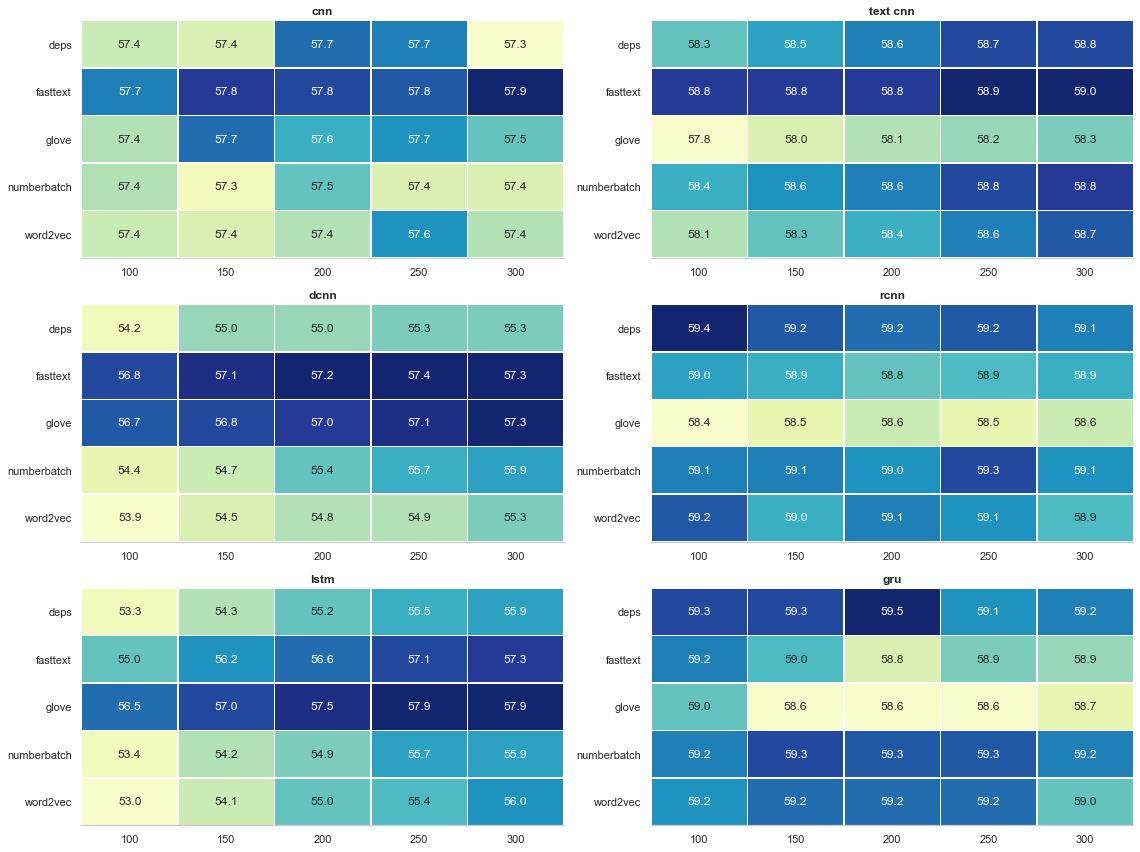

In [17]:
# Get test and validation accuracy for each model
embed_acc_data = embed_mean_data.drop(embed_mean_data.columns.difference(['model_name'] + exp_params + ['val_acc', 'test_acc']), axis=1)

g, fig = plot_facetgrid(embed_acc_data, x='embedding_type', y='embedding_dim', hue='val_acc', col='model_name',
                        kind='heatmap', title='', y_label='', x_label='', num_col=2, colour='YlGnBu', num_colour=20,
                        annot=True, fmt='0.3', linewidths=0.5, cbar=False, height=4)
g.savefig(os.path.join(task_name, 'embedding_type', 'embedding_type_accuracy.png'))

Test RM ANOVA assumptions using Shapiro-Wilks test for normality and Mauchly test for sphericity.

Perform Two-way RM ANOVA for each model, comparing different embedding type and dimension groups.

In [18]:
# Set the metric to test
metric = 'val_acc'

# Add embedding type and dimension column
embed_data['embedding_params'] = embed_data.apply(lambda row: row['embedding_type'] + "_" + str(row['embedding_dim']), axis=1)

# Run Shaprio-wilks test for normal distribution
shapiro_wilk_test(embed_data, 'embedding_params', metric)

# Run Mauchly test for sphericity
mauchly_test(embed_data, 'embedding_params', metric)

# Run Two-way RM ANOVA
embedd_aov = rm_two_way_anova_test(embed_data, exp_params, metric, sig_level=alpha, show_result=True)
embedd_aov.round(5)

The following embedding_params are not normally distributed.
    model_name embedding_params    t-stat   p-value
0          cnn        glove_100  0.724160  0.001730
46    text cnn         deps_100  0.835564  0.039036
80        rcnn     word2vec_200  0.759798  0.004697
91        rcnn     word2vec_300  0.791048  0.011284
93        rcnn        glove_150  0.840905  0.045239
106       lstm  numberbatch_250  0.815921  0.022620
121       lstm     fasttext_150  0.831388  0.034773
128        gru  numberbatch_200  0.844072  0.049363
136        gru         deps_250  0.803581  0.016026
143        gru  numberbatch_100  0.812123  0.020346
145        gru     word2vec_200  0.749421  0.003511
All models embedding_params sphericity assumption is met.
The following models do not have significant p-values when comparing ['embedding_type', 'embedding_dim'] groups.
   model_name                          Source        SS  ddof1  ddof2        MS         F     p-unc  p-GG-corr       np2       eps
1         cnn

,model_name,Source,SS,ddof1,ddof2,MS,F,p-unc,p-GG-corr,np2,eps
0,cnn,embedding_type,4.31542,4,36,1.07885,23.92532,0.00000,0.00000,0.72665,0.71854
1,cnn,embedding_dim,0.80026,4,36,0.20006,2.34365,0.07322,0.10852,0.20660,0.62883
2,cnn,embedding_type * embedding_dim,1.90505,16,144,0.11907,1.53503,0.09501,0.20641,0.14571,0.27671
3,text cnn,embedding_type,16.61236,4,36,4.15309,125.65546,0.00000,0.00000,0.93316,0.85562
4,text cnn,embedding_dim,5.46161,4,36,1.36540,21.24908,0.00000,0.00000,0.70247,0.73872
5,text cnn,embedding_type * embedding_dim,0.69800,16,144,0.04363,0.99191,0.46887,0.42635,0.09927,0.26174
6,dcnn,embedding_type,276.33453,4,36,69.08363,349.55273,0.00000,0.00000,0.97490,0.69398
7,dcnn,embedding_dim,32.27052,4,36,8.06763,48.91265,0.00000,0.00000,0.84459,0.65229
8,dcnn,embedding_type * embedding_dim,7.16765,16,144,0.44798,3.00413,0.00024,0.02478,0.25026,0.28173
9,rcnn,embedding_type,14.60814,4,36,3.65204,40.02684,0.00000,0.00000,0.81643,0.53394


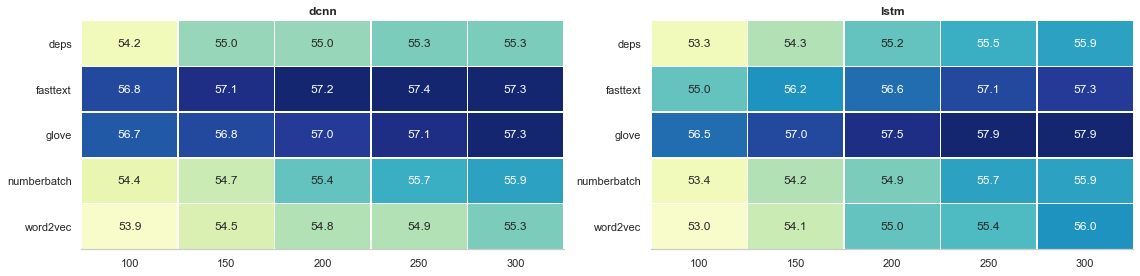

In [19]:
# Get only models that show significant effect
heatmap_data = embed_acc_data.loc[(embed_acc_data['model_name'] == 'dcnn') | (embed_acc_data['model_name'] == 'lstm')]

# Generate accuracy heatmap
g, fig = plot_facetgrid(heatmap_data, x='embedding_type', y='embedding_dim', hue='val_acc', col='model_name',
                        kind='heatmap', title='', y_label='', x_label='', num_col=2, colour='YlGnBu', num_colour=20,
                        annot=True, fmt='0.3', linewidths=0.5, cbar=False, height=4)
g.savefig(os.path.join(task_name, 'embedding_type', 'embedding_type_dcnn_accuracy.png'))

Pairwise Bayes sign rank

In [ ]:
# # Set the metric to test
# metric = 'val_acc'
#
# # Multi-pairwise Bayes takes a long time to calculate, so save/load as needed
# # embed_data['embedd_val'] = embed_data.apply(lambda  row: row['embedding_type'] + '-' + str(row['embedding_dim']), axis=1)
# # embed_bayes_frame = multi_pairwise_bayes_signrank(embed_data, 'model_name', 'embedd_val', metric, rope=0.5)
# # save_dataframe(os.path.join(task_name, 'embedding_type', 'embedding_type_bayes_results.csv'), embed_bayes_frame)
#
# embed_bayes_frame = load_dataframe(os.path.join(task_name, 'embedding_type', 'embedding_type_bayes_results.csv'))
#
# # Generate heatmaps
# embed_bayes_right = embed_bayes_frame.loc[embed_bayes_frame['right'] >= 0.8]
# g, fig = plot_facetgrid(embed_bayes_right, x='model_A', y='model_B', hue='right', col='model_name', kind='heatmap',
#                         title='P(B > A)', y_label='A', x_label='B', num_col=2, colour='RdBu_r',
#                         annot=True, fmt='0.2', linewidths=0.5, cbar=False, custom_boundaries=[0.0, 0.8, 1.0],
#                         x_tick_rotation=45, y_tick_rotation=45, height=6)
# fig.show()
#
# embed_bayes_left = embed_bayes_frame.loc[embed_bayes_frame['left'] >= 0.8]
# g, fig = plot_facetgrid(embed_bayes_left, x='model_A', y='model_B', hue='left', col='model_name', kind='heatmap',
#                         title='P(A > B)', y_label='A', x_label='B', num_col=2, colour='RdBu_r',
#                         annot=True, fmt='0.2', linewidths=0.5, cbar=False, custom_boundaries=[0.0, 0.8, 1.0],
#                         x_tick_rotation=45, y_tick_rotation=45, height=6)
# fig.show()
#
# embed_bayes_frame.round(3)

Embedding dim only

In [32]:
# Set the metric to test
metric = 'val_acc'

# Multi-pairwise Bayes takes a long time to calculate, so save/load as needed
# embed_dim_bayes_frame = pd.DataFrame()
# # Get each embedding type for each model
# for model_name in embed_data['model_name'].unique():
#     for embed_type in embed_data['embedding_type'].unique():
#         type_data = embed_data.loc[(embed_data['model_name'] == model_name) & (embed_data['embedding_type'] == embed_type)]
#         # Run Bayes only comparing the dimension for that type
#         cur_bayes = pairwise_bayes_signrank(type_data, 'embedding_dim', metric, rope=0.5)
#         cur_bayes.insert(0, 'model_name', model_name)
#         cur_bayes.insert(1, 'embed_type', embed_type)
#         embed_dim_bayes_frame = pd.concat([embed_dim_bayes_frame, cur_bayes], axis=0)
# save_dataframe(os.path.join(task_name, 'embedding_type', 'embedding_dim-only_bayes_results.csv'), embed_dim_bayes_frame)

embed_dim_bayes_frame = load_dataframe(os.path.join(task_name, 'embedding_type', 'embedding_dim-only_bayes_results.csv'))
embed_dim_bayes_frame.drop('index', axis=1, inplace=True)


# Show only where there are significant results
embed_dim_bayes_frame = embed_dim_bayes_frame.loc[(embed_dim_bayes_frame['left'] >= 0.8) | (embed_dim_bayes_frame['right'] >= 0.8)]
embed_dim_bayes_frame.round(3)

,model_name,embed_type,model_A,model_B,P({a} > {b}),P({a} == {b}),P({b} > {a}),left,within,right
88,text cnn,word2vec,300,100,0.866,0.134,0.000,0.866,0.134,0.000
110,dcnn,numberbatch,100,250,0.000,0.000,1.000,0.000,0.000,1.000
113,dcnn,numberbatch,150,250,0.000,0.010,0.990,0.000,0.010,0.990
114,dcnn,numberbatch,200,100,0.991,0.009,0.000,0.991,0.009,0.000
116,dcnn,numberbatch,300,100,1.000,0.000,0.000,1.000,0.000,0.000
117,dcnn,numberbatch,300,150,0.999,0.001,0.000,0.999,0.001,0.000
132,dcnn,word2vec,200,100,0.964,0.036,0.000,0.964,0.036,0.000
135,dcnn,word2vec,250,100,0.976,0.024,0.000,0.976,0.024,0.000
139,dcnn,word2vec,300,100,0.996,0.004,0.000,0.996,0.004,0.000
140,dcnn,deps,100,200,0.000,0.123,0.877,0.000,0.123,0.877


Embedding type only

In [35]:
# Set the metric to test
metric = 'val_acc'

# Multi-pairwise Bayes takes a long time to calculate, so save/load as needed
# embed_type_bayes_frame = multi_pairwise_bayes_signrank(embed_data, 'model_name', 'embedding_type', metric, rope=0.5)
# save_dataframe(os.path.join(task_name, 'embedding_type', 'embedding_type-only_bayes_results.csv'), embed_type_bayes_frame)

embed_type_bayes_frame = load_dataframe(os.path.join(task_name, 'embedding_type', 'embedding_type-only_bayes_results.csv'))
embed_type_bayes_frame.drop('index', axis=1, inplace=True)

# Show only where there are significant results
embed_type_bayes_frame = embed_type_bayes_frame.loc[(embed_type_bayes_frame['left'] >= 0.8) | (embed_type_bayes_frame['right'] >= 0.8)]
embed_type_bayes_frame.round(3)

,model_name,model_A,model_B,P({a} > {b}),P({a} == {b}),P({b} > {a}),left,within,right
13,text cnn,glove,fasttext,0.000,0.000,1.000,0.000,0.000,1.000
14,text cnn,glove,numberbatch,0.000,0.171,0.829,0.000,0.171,0.829
20,dcnn,fasttext,deps,1.000,0.000,0.000,1.000,0.000,0.000
21,dcnn,fasttext,word2vec,1.000,0.000,0.000,1.000,0.000,0.000
22,dcnn,glove,deps,1.000,0.000,0.000,1.000,0.000,0.000
24,dcnn,glove,numberbatch,1.000,0.000,0.000,1.000,0.000,0.000
25,dcnn,glove,word2vec,1.000,0.000,0.000,1.000,0.000,0.000
27,dcnn,numberbatch,fasttext,0.000,0.000,1.000,0.000,0.000,1.000
28,dcnn,numberbatch,word2vec,0.818,0.182,0.000,0.818,0.182,0.000
32,rcnn,glove,deps,0.000,0.000,1.000,0.000,0.000,1.000


# Input sequence and embeddings final results

Results for the 6 base models using the parameters (vocabulary size, sequence length and embeddings) from previous experiments.

In [4]:
# Name of the experiment parameter for comparison
exp_param = 'input_seq_final'

# Load language models experiment data
inseq_final_data = load_dataframe(os.path.join(task_name, exp_param, exp_param + '_data.csv'))
inseq_final_mean_data = load_dataframe(os.path.join(task_name,  exp_param, exp_param + '_mean_data.csv'))

# Get the max values for each model
print("Best validation accuracy in mean data:")
print(inseq_final_mean_data.loc[[inseq_final_mean_data['val_acc'].idxmax()], ['model_name', 'val_acc', 'val_acc_std']])
print("Best test accuracy in mean data:")
print(inseq_final_mean_data.loc[[inseq_final_mean_data['test_acc'].idxmax()], ['model_name', 'test_acc', 'test_acc_std', 'f1_weighted', 'f1_weighted_std']])
inseq_final_data_max = get_max(inseq_final_mean_data, [])
inseq_final_data_max.round({'val_acc': acc_round_val, 'val_acc_std': acc_round_val, 'test_acc':acc_round_val, 'test_acc_std':acc_round_val, 'f1_weighted' :f1_round_val, 'f1_weighted_std' :f1_round_val})

Best validation accuracy in mean data:
  model_name    val_acc  val_acc_std
3       rcnn  58.731445     0.202454
Best test accuracy in mean data:
  model_name   test_acc  test_acc_std  f1_weighted  f1_weighted_std
5        gru  61.121407      0.638604     0.599533         0.004747


,model_name,val_acc,val_acc_std,test_acc,test_acc_std,f1_weighted,f1_weighted_std
0,cnn,57.58,0.24,59.22,1.01,0.5720,0.0101
1,text cnn,58.54,0.24,60.24,0.63,0.5888,0.0049
2,dcnn,57.73,0.39,59.96,0.58,0.5815,0.0058
3,rcnn,58.73,0.20,60.43,0.62,0.5917,0.0050
4,lstm,58.15,0.15,59.86,0.62,0.5870,0.0080
5,gru,58.49,0.36,61.12,0.64,0.5995,0.0047


# Model variants results

Results and comparison for the bi-directional and multi-layer for recurrent models.
Results and comparison for the attentional variants of all 6 base models.

In [5]:
# Name of the experiment parameter for comparison
exp_param = 'model_variants'
metric = 'val_acc'

# Load language models experiment data
variants_data = load_dataframe(os.path.join(task_name, exp_param, exp_param + '_data.csv'))
variants_mean_data = load_dataframe(os.path.join(task_name,  exp_param, exp_param + '_mean_data.csv'))

# Remove CRF because they are strictly worse
variants_data = variants_data[~variants_data['model_name'].str.contains('crf')]
variants_mean_data = variants_mean_data[~variants_mean_data['model_name'].str.contains('crf')]

# Get the max values for each model
print("Best validation accuracy in mean data:")
print(variants_mean_data.loc[[variants_mean_data['val_acc'].idxmax()], ['model_name', 'val_acc', 'val_acc_std']])
print("Best test accuracy in mean data:")
print(variants_mean_data.loc[[variants_mean_data['test_acc'].idxmax()], ['model_name', 'test_acc', 'test_acc_std', 'f1_weighted', 'f1_weighted_std']])
variants_data_max = get_max(variants_mean_data, [])
variants_data_max.round({'val_acc': acc_round_val, 'val_acc_std': acc_round_val, 'test_acc':acc_round_val, 'test_acc_std':acc_round_val, 'f1_weighted' :f1_round_val, 'f1_weighted_std' :f1_round_val})

Best validation accuracy in mean data:
       model_name    val_acc  val_acc_std
13  text cnn attn  58.550391     0.301326
Best test accuracy in mean data:
  model_name   test_acc  test_acc_std  f1_weighted  f1_weighted_std
0     bi gru  61.165229      0.693715     0.595887         0.006026


,model_name,val_acc,val_acc_std,test_acc,test_acc_std,f1_weighted,f1_weighted_std
0,bi gru,58.51,0.44,61.17,0.69,0.5959,0.0060
1,bi lstm,57.94,0.17,59.73,0.62,0.5835,0.0051
2,cnn attn,58.03,0.21,59.68,0.36,0.5764,0.0073
3,dcnn attn,57.47,0.23,59.96,0.35,0.5805,0.0056
4,deep gru 2lyr,57.96,0.35,60.04,0.64,0.5852,0.0049
5,deep gru 3lyr,57.48,0.28,59.17,1.01,0.5802,0.0094
6,deep lstm 2lyr,58.32,0.17,59.94,0.68,0.5837,0.0080
7,deep lstm 3lyr,58.10,0.24,60.02,0.70,0.5859,0.0058
8,gru attn,58.43,0.15,60.59,0.47,0.5921,0.0041
9,lstm attn,58.09,0.20,59.91,0.47,0.5848,0.0043


Merge base and variant results

In [6]:
# Merge all of the supervised models results
final_data = pd.concat([inseq_final_data, variants_data], ignore_index=True)
final_data.drop('index', axis=1, inplace=True)

final_mean_data = pd.concat([inseq_final_mean_data, variants_mean_data], ignore_index=True)
final_mean_data.drop('index', axis=1, inplace=True)
final_mean_data = final_mean_data.drop(final_mean_data.columns.difference(['model_name', 'val_acc', 'val_acc_std',
                                                                           'test_acc', 'test_acc_std', 'f1_weighted',
                                                                           'f1_weighted_std']), axis=1)

### Multi-layer

Test assumptions using Shapiro-Wilks test for normality and Mauchly test for sphericity.
Run RM ANOVA between recurrent models and their multi layer (2 and 3 layers) variants.

In [7]:
# Get only the recurrent models and variants
deep_lstm_data = final_data[~final_data.model_name.str.contains('attn|cnn|rcnn|dcnn|gru|bi')]
deep_lstm_mean_data = final_mean_data[~final_mean_data.model_name.str.contains('attn|cnn|rcnn|dcnn|gru|bi')]

deep_gru_data = final_data[~final_data.model_name.str.contains('attn|cnn|rcnn|dcnn|lstm|bi')]
deep_gru_mean_data = final_mean_data[~final_mean_data.model_name.str.contains('attn|cnn|rcnn|dcnn|lstm|bi')]

# Show multi-layer results
deep_recurrent_data = pd.concat([deep_lstm_mean_data, deep_gru_mean_data], ignore_index=True)
deep_recurrent_data = deep_recurrent_data[['model_name', 'val_acc', 'val_acc_std','test_acc', 'test_acc_std', 'f1_weighted', 'f1_weighted_std']]
deep_recurrent_data.round({'val_acc': acc_round_val, 'val_acc_std': acc_round_val, 'test_acc':acc_round_val, 'test_acc_std':acc_round_val, 'f1_weighted' :f1_round_val, 'f1_weighted_std' :f1_round_val})

,model_name,val_acc,val_acc_std,test_acc,test_acc_std,f1_weighted,f1_weighted_std
0,lstm,58.15,0.15,59.86,0.62,0.5870,0.0080
1,deep lstm 2lyr,58.32,0.17,59.94,0.68,0.5837,0.0080
2,deep lstm 3lyr,58.10,0.24,60.02,0.70,0.5859,0.0058
3,gru,58.49,0.36,61.12,0.64,0.5995,0.0047
4,deep gru 2lyr,57.96,0.35,60.04,0.64,0.5852,0.0049
5,deep gru 3lyr,57.48,0.28,59.17,1.01,0.5802,0.0094


In [9]:
print("#### LSTM Multi-layer Variants ####")

# Run Shaprio-wilks test for normal distribution
shapiro_wilk_test(deep_lstm_data, 'model_name', metric)

# Run ANOVA
deep_lstm_anova = rm_one_way_anova_test(deep_lstm_data, 'model_name', metric, sig_level=alpha)
print(deep_lstm_anova)

# Run Tukey-HSD post-hoc analysis
tukey_hsd(deep_lstm_data, 'model_name', metric)

# Run pairwise bayes sign-rank
print("Bayes sign-rank:")
_ = pairwise_bayes_signrank(deep_lstm_data, 'model_name', metric, rope=0.5, show_result=True)

print("#### GRU Multi-layer Variants ####")

# Run Shaprio-wilks test for normal distribution
shapiro_wilk_test(deep_gru_data, 'model_name', metric)

# Run ANOVA
deep_gru_anova = rm_one_way_anova_test(deep_gru_data, 'model_name', metric, sig_level=alpha)
print(deep_gru_anova)

# Run Tukey-HSD post-hoc analysis
tukey_hsd(deep_gru_data, 'model_name', metric)

# Run pairwise bayes sign-rank
print("Bayes sign-rank:")
_ = pairwise_bayes_signrank(deep_gru_data, 'model_name', metric, rope=0.5, show_result=True)

#### LSTM Multi-layer Variants ####
All models model_name are normally distributed.
The models do not have significant p-values when comparing groups. P-value = 0.05391
       Source        SS  DF        MS         F     p-unc  p-GG-corr       np2       eps sphericity   W-spher   p-spher   cohen_f   n      exp_n    power  exp_power
0  model_name  0.268744   2  0.134372  3.650234  0.046698    0.05391  0.288551  0.887348       True  0.873046  0.580964  0.250102  30  60.224814  0.36816        0.8
1       Error  0.662615  18  0.036812       NaN       NaN        NaN       NaN       NaN        NaN       NaN       NaN  0.250102  30  60.224814  0.36816        0.8
        Multiple Comparison of Means - Tukey HSD, FWER=0.05         
    group1         group2     meandiff p-adj   lower   upper  reject
--------------------------------------------------------------------
deep lstm 2lyr deep lstm 3lyr  -0.2225  0.036 -0.4323 -0.0127   True
deep lstm 2lyr           lstm  -0.1676 0.1364 -0.3774  0.042

### Bi-directional

In [10]:
# Get only base and bi-directional models
bi_lstm_data = final_data[~final_data.model_name.str.contains('attn|cnn|rcnn|dcnn|gru|deep')]
bi_lstm_mean_data = final_mean_data[~final_mean_data.model_name.str.contains('attn|cnn|rcnn|dcnn|gru|deep')]

bi_gru_data = final_data[~final_data.model_name.str.contains('attn|cnn|rcnn|dcnn|lstm|deep')]
bi_gru_mean_data = final_mean_data[~final_mean_data.model_name.str.contains('attn|cnn|rcnn|dcnn|lstm|deep')]

# Show bi-directional results
bi_directional_data = pd.concat([bi_lstm_mean_data, bi_gru_mean_data], ignore_index=True)
bi_directional_data = bi_directional_data[['model_name', 'val_acc', 'val_acc_std','test_acc', 'test_acc_std', 'f1_weighted', 'f1_weighted_std']]
bi_directional_data.round({'val_acc': acc_round_val, 'val_acc_std': acc_round_val, 'test_acc':acc_round_val, 'test_acc_std':acc_round_val, 'f1_weighted' :f1_round_val, 'f1_weighted_std' :f1_round_val})

,model_name,val_acc,val_acc_std,test_acc,test_acc_std,f1_weighted,f1_weighted_std
0,lstm,58.15,0.15,59.86,0.62,0.5870,0.0080
1,bi lstm,57.94,0.17,59.73,0.62,0.5835,0.0051
2,gru,58.49,0.36,61.12,0.64,0.5995,0.0047
3,bi gru,58.51,0.44,61.17,0.69,0.5959,0.0060


Run Wilcoxon and Bayes sign rank test comparing base recurrent models and their bi-directional variants.

In [11]:
print("#### LSTM Bi-directional Variants ####")

# Select the data to compare
data_a = bi_lstm_data.loc[(bi_lstm_data['model_name'] == 'lstm')][metric]
data_b = bi_lstm_data.loc[(bi_lstm_data['model_name'] == 'bi lstm')][metric]

# Wilcoxon test (with continuity correction)
stats = pg.wilcoxon(data_a, data_b).to_dict(orient='records')[0]
power = pg.power_chi2(dof=1, w=stats['RBC'], n=20, alpha=alpha)
exp_n = int(pg.power_chi2(dof=1, w=stats['RBC'], power=power, alpha=alpha))

print("w-stat = " + str(round(stats['W-val'], 5)) + " p-value = " + str(round(stats['p-val'], 5)) +
      ' n = ' + str(exp_n) + ' power = ' + str(round(power, 5)))

# Bayes sign-rank test
_ = bayes_signrank(data_a.tolist(), data_b.tolist(), 'lstm', 'bi lstm', rope=0.5, show_result=True)

print("#### GRU Bi-directional Variants ####")

# Select the data to compare
data_a = bi_gru_data.loc[(bi_gru_data['model_name'] == 'gru')][metric]
data_b = bi_gru_data.loc[(bi_gru_data['model_name'] == 'bi gru')][metric]

# Wilcoxon test (with continuity correction)
stats = pg.wilcoxon(data_a, data_b).to_dict(orient='records')[0]
power = pg.power_chi2(dof=1, w=stats['RBC'], n=20, alpha=alpha)
exp_n = int(pg.power_chi2(dof=1, w=stats['RBC'], power=power, alpha=alpha))

print("w-stat = " + str(round(stats['W-val'], 5)) + " p-value = " + str(round(stats['p-val'], 5)) +
      ' n = ' + str(exp_n) + ' power = ' + str(round(power, 5)))

# Bayes sign-rank test
_ = bayes_signrank(data_a.tolist(), data_b.tolist(), 'gru', 'bi gru', rope=0.5, show_result=True)

#### LSTM Bi-directional Variants ####
w-stat = 5.0 p-value = 0.02493 n = 20 power = 0.86064
P(lstm > bi lstm) = 0.00044, P(lstm == bi lstm) = 0.99956, P(bi lstm > lstm) = 0.0
#### GRU Bi-directional Variants ####
w-stat = 24.0 p-value = 0.75977 n = 20 power = 0.02322
P(gru > bi gru) = 0.00584, P(gru == bi gru) = 0.99378, P(bi gru > gru) = 0.00038


### Attention

In [12]:
# Get only base and attentional models
attn_data = final_data[~final_data.model_name.str.contains('bi|deep|crf')]
attn_mean_data = final_mean_data[~final_mean_data.model_name.str.contains('bi|deep|crf')]

# Show attentional results
attn_mean_data = attn_mean_data[['model_name', 'val_acc', 'val_acc_std','test_acc', 'test_acc_std', 'f1_weighted', 'f1_weighted_std']]
attn_mean_data.round({'val_acc': acc_round_val, 'val_acc_std': acc_round_val, 'test_acc':acc_round_val, 'test_acc_std':acc_round_val, 'f1_weighted' :f1_round_val, 'f1_weighted_std' :f1_round_val})

,model_name,val_acc,val_acc_std,test_acc,test_acc_std,f1_weighted,f1_weighted_std
0,cnn,57.58,0.24,59.22,1.01,0.5720,0.0101
1,text cnn,58.54,0.24,60.24,0.63,0.5888,0.0049
2,dcnn,57.73,0.39,59.96,0.58,0.5815,0.0058
3,rcnn,58.73,0.20,60.43,0.62,0.5917,0.0050
4,lstm,58.15,0.15,59.86,0.62,0.5870,0.0080
5,gru,58.49,0.36,61.12,0.64,0.5995,0.0047
8,cnn attn,58.03,0.21,59.68,0.36,0.5764,0.0073
9,dcnn attn,57.47,0.23,59.96,0.35,0.5805,0.0056
14,gru attn,58.43,0.15,60.59,0.47,0.5921,0.0041
15,lstm attn,58.09,0.20,59.91,0.47,0.5848,0.0043


Run Wilcoxon sign rank test comparing base models and their attentional variants.

In [28]:
# Create results frame
wilcox_test_frame = pd.DataFrame(columns=['model_name', 'p-value'])

# Perform wilcoxon for each model and its attn variant
for model in ['cnn', 'text cnn', 'dcnn', 'rcnn', 'lstm', 'gru']:

    current_attn_data = attn_data.loc[(attn_data['model_name'] == model) | (attn_data['model_name'] == model + ' attn')]

    # Select the data to compare
    data_a = attn_data.loc[(attn_data['model_name'] == model)][metric]
    data_b = attn_data.loc[(attn_data['model_name'] == model + ' attn')][metric]

    # Wilcoxon test (with continuity correction)
    stats = pg.wilcoxon(data_a, data_b).to_dict(orient='records')[0]
    power = pg.power_chi2(dof=1, w=stats['RBC'], n=20, alpha=alpha)
    exp_n = int(pg.power_chi2(dof=1, w=stats['RBC'], power=power, alpha=alpha))

    # Append to result frame
    wilcox_test_frame = wilcox_test_frame.append({'model_name': model, 'w-stat': stats['W-val'], 'p-value': stats['p-val'],
                                                  'effect': stats['RBC'], 'exp_n': exp_n, 'power': power, 'exp_power': 0.8},
                                                 ignore_index=True)


if all(p_value <= alpha for p_value in wilcox_test_frame['p-value']):
    print("All models have significant p-values when comparing attention groups.")
else:
    print("The following models do not have significant p-values when comparing attention groups.")
    print(wilcox_test_frame.loc[wilcox_test_frame['p-value'] > alpha])

wilcox_test_frame.round(5)

The following models do not have significant p-values when comparing attention groups.
  model_name   p-value    effect  exp_n  exp_power     power  w-stat
1   text cnn  0.838464 -0.090909   19.0        0.8  0.016461    25.0
2       dcnn  0.308063  0.381818   20.0        0.8  0.192628    17.0
3       rcnn  0.126279  0.563636   20.0        0.8  0.478001    12.0
4       lstm  0.262193  0.418182   20.0        0.8  0.240203    16.0
5        gru  0.838464  0.090909   19.0        0.8  0.016461    25.0


,model_name,p-value,effect,exp_n,exp_power,power,w-stat
0,cnn,0.00592,-1.00000,19.0,0.8,0.97104,0.0
1,text cnn,0.83846,-0.09091,19.0,0.8,0.01646,25.0
2,dcnn,0.30806,0.38182,20.0,0.8,0.19263,17.0
3,rcnn,0.12628,0.56364,20.0,0.8,0.47800,12.0
4,lstm,0.26219,0.41818,20.0,0.8,0.24020,16.0
5,gru,0.83846,0.09091,19.0,0.8,0.01646,25.0


Run Bayes sign-rank

In [13]:
for model_name in ['cnn', 'text cnn', 'dcnn', 'rcnn', 'lstm', 'gru']:
    # Get current model data to lists
    current_attn_data = attn_data.loc[(attn_data['model_name'] == model_name) | (attn_data['model_name'] == model_name + ' attn')]

    # Select the data to compare
    no_attn = attn_data.loc[(attn_data['model_name'] == model_name)]['val_acc'].tolist()
    attn = attn_data.loc[(attn_data['model_name'] == model_name + ' attn')]['val_acc'].tolist()

    # Pair data into 2d array
    curr_data = pair_data(no_attn, attn)

    # Apply Bayesian sign rank
    left, within, right = bt.signrank(curr_data, rope=0.5, verbose=False)
    print('Model: {m1} P({c1} > {c2}) = {pl}, P(rope) = {pe}, P({c2} > {c1}) = {pr}'.
          format(m1=model_name, c1='no_attn', c2='attn', pl=left, pe=within, pr=right))

Model: cnn P(no_attn > attn) = 0.0, P(rope) = 0.80816, P(attn > no_attn) = 0.19184
Model: text cnn P(no_attn > attn) = 0.0, P(rope) = 0.99998, P(attn > no_attn) = 2e-05
Model: dcnn P(no_attn > attn) = 0.05688, P(rope) = 0.94312, P(attn > no_attn) = 0.0
Model: rcnn P(no_attn > attn) = 0.0047, P(rope) = 0.9953, P(attn > no_attn) = 0.0
Model: lstm P(no_attn > attn) = 0.0, P(rope) = 1.0, P(attn > no_attn) = 0.0
Model: gru P(no_attn > attn) = 0.0015, P(rope) = 0.99828, P(attn > no_attn) = 0.00022


# Language Models

Using pre-trained language models to generate sequence representations.

In [14]:
# Name of the experiment parameter for comparison
exp_param = 'embedding_type'

# Load language models experiment data
lm_data = load_dataframe(os.path.join(task_name, 'language_models', 'language_models_data.csv'))
lm_mean_data = load_dataframe(os.path.join(task_name, 'language_models', 'language_models_mean_data.csv'))

# Get the max values for each model
print("Best validation accuracy in mean data:")
print(lm_mean_data.loc[[lm_mean_data['val_acc'].idxmax()], ['model_name', 'val_acc', 'val_acc_std']])
print("Best test accuracy in mean data:")
print(lm_mean_data.loc[[lm_mean_data['test_acc'].idxmax()], ['model_name', 'test_acc', 'test_acc_std', 'f1_weighted', 'f1_weighted_std']])
lm_data_max = get_max(lm_mean_data, [exp_param])
lm_data_max.drop('embedding_type', axis=1, inplace=True)
lm_data_max.round({'val_acc': acc_round_val, 'val_acc_std': acc_round_val, 'test_acc':acc_round_val, 'test_acc_std':acc_round_val, 'f1_weighted' :f1_round_val, 'f1_weighted_std' :f1_round_val})

Best validation accuracy in mean data:
  model_name   val_acc  val_acc_std
4      xlnet  61.20519     0.508708
Best test accuracy in mean data:
  model_name   test_acc  test_acc_std  f1_weighted  f1_weighted_std
0       bert  62.907314      0.324844      0.61083         0.005399


,model_name,val_acc,val_acc_std,test_acc,test_acc_std,f1_weighted,f1_weighted_std
0,bert,61.12,0.44,62.91,0.32,0.6108,0.0054
1,roberta,61.18,0.40,62.63,0.24,0.6071,0.0065
2,gpt2,60.18,0.28,61.04,0.98,0.5902,0.0112
3,dialogpt,57.04,1.83,56.70,1.85,0.5406,0.0209
4,xlnet,61.21,0.51,61.61,0.78,0.5945,0.0112
5,convert,58.16,0.21,60.94,0.63,0.5908,0.0054
6,elmo,58.34,0.21,60.44,0.35,0.5854,0.0028
7,use,59.35,0.22,60.67,0.56,0.5892,0.0046
8,mlstm char lm,58.50,0.27,60.79,0.63,0.5937,0.0047
9,nnlm,52.44,0.18,56.65,0.24,0.5385,0.0032


Plot accuracy of each language model.

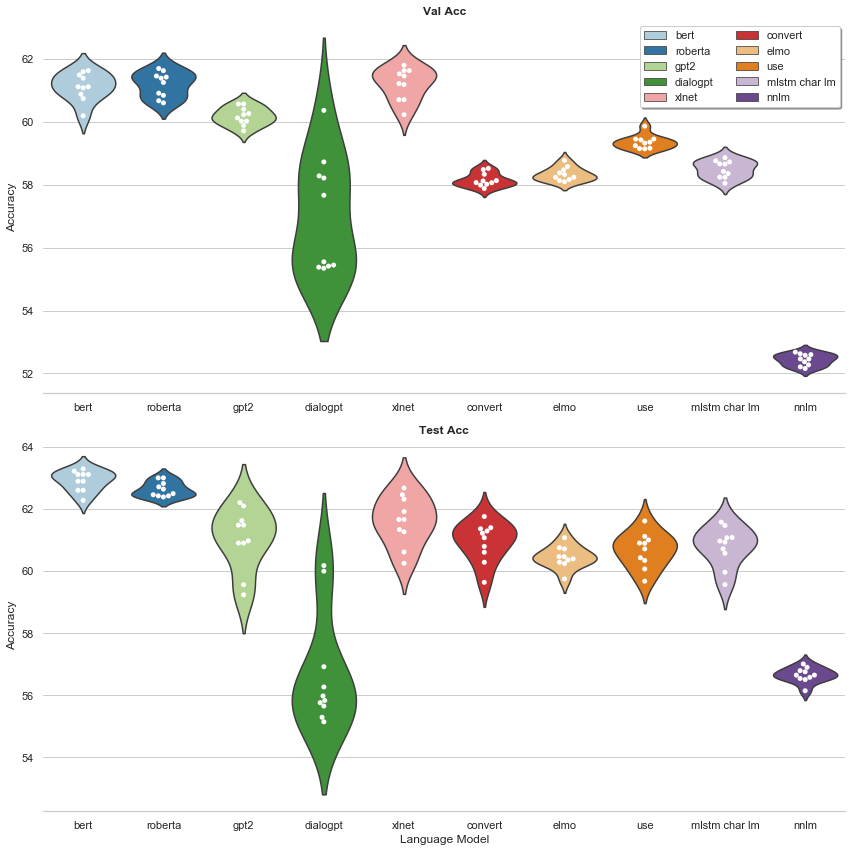

In [31]:
# Get test and validation accuracy for each model
lm_acc_data = lm_data.drop(lm_data.columns.difference(['model_name', exp_param, 'val_acc', 'test_acc']), axis=1)
lm_acc_data = lm_acc_data.rename(columns={'val_acc': 'Val Acc', 'test_acc': 'Test Acc'})
lm_acc_data = lm_acc_data.melt(id_vars=['model_name', exp_param])

g, fig = plot_facetgrid(lm_acc_data, x="model_name", y="value", hue="model_name", col='variable', kind='swarm_violin',
                        num_legend_col=2, y_label='Accuracy', x_label='Language Model',
                        share_y=False, num_col=1, colour='Paired', dodge=False)
g.savefig(os.path.join(task_name, 'language_models', 'language_models' + '_accuracy.png'))

Run Wilcoxon sign rank test to compare each language models with the best supervised model.

In [32]:
# Set the metric to test
metric = 'test_acc'

# Create results frame
wilcox_lm_test_frame = pd.DataFrame(columns=['model_name', 'p-value'])

# Perform t-test for each model and its attn variant
for model_name in (lm_data['model_name'].unique()):

    # Select the data to compare
    data_a = lm_data.loc[(lm_data['model_name'] == model_name)][metric]
    data_b = final_data.loc[(final_data['model_name'] == 'bi gru')][metric]

    # Wilcoxon test (with continuity correction)
    stats = pg.wilcoxon(data_a, data_b).to_dict(orient='records')[0]
    power = pg.power_chi2(dof=1, w=stats['RBC'], n=20, alpha=alpha)
    exp_n = int(pg.power_chi2(dof=1, w=stats['RBC'], power=power, alpha=alpha))

    # Append to result frame
    wilcox_lm_test_frame = wilcox_lm_test_frame.append({'model_name': model_name, 'w-stat': stats['W-val'], 'p-value': stats['p-val'],
                                                        'effect': stats['RBC'], 'exp_n': exp_n, 'power': power, 'exp_power': 0.8},
                                                       ignore_index=True)


if all(p_value <= alpha for p_value in wilcox_lm_test_frame['p-value']):
    print("All models have significant p-values when comparing best lm and supervised groups.")
else:
    print("The following models do not have significant p-values when comparing best lm and supervised groups.")
    print(wilcox_lm_test_frame.loc[wilcox_lm_test_frame['p-value'] > alpha])

wilcox_lm_test_frame.round(5)

The following models do not have significant p-values when comparing best lm and supervised groups.
      model_name   p-value    effect  exp_n  exp_power     power  w-stat
2           gpt2  0.918813  0.054545   20.0        0.8  0.012256    26.0
4          xlnet  0.066546  0.672727   20.0        0.8  0.667383     9.0
5        convert  0.540818 -0.236364   20.0        0.8  0.064549    21.0
6           elmo  0.032313 -0.781818   20.0        0.8  0.821362     6.0
7            use  0.153576 -0.527273   20.0        0.8  0.413795    13.0
8  mlstm char lm  0.185144 -0.490909   20.0        0.8  0.351819    14.0


,model_name,p-value,effect,exp_n,exp_power,power,w-stat
0,bert,0.00592,1.00000,19.0,0.8,0.97104,0.0
1,roberta,0.00592,1.00000,19.0,0.8,0.97104,0.0
2,gpt2,0.91881,0.05455,20.0,0.8,0.01226,26.0
3,dialogpt,0.00592,-1.00000,19.0,0.8,0.97104,0.0
4,xlnet,0.06655,0.67273,20.0,0.8,0.66738,9.0
5,convert,0.54082,-0.23636,20.0,0.8,0.06455,21.0
6,elmo,0.03231,-0.78182,20.0,0.8,0.82136,6.0
7,use,0.15358,-0.52727,20.0,0.8,0.41380,13.0
8,mlstm char lm,0.18514,-0.49091,20.0,0.8,0.35182,14.0
9,nnlm,0.00592,-1.00000,19.0,0.8,0.97104,0.0


Run Bayes sign-rank

In [15]:
# Perform t-test for each model and its attn variant
for model_name in (lm_data['model_name'].unique()):

    # Select the data to compare
    data_a = lm_data.loc[(lm_data['model_name'] == model_name)][metric].tolist()
    data_b = final_data.loc[(final_data['model_name'] == 'bi gru')][metric].tolist()

    # Pair data into 2d array
    curr_data = pair_data(data_a, data_b)

    # Apply Baysian sign rank
    left, within, right = bt.signrank(curr_data, rope=0.5, verbose=False)
    print('Model: {m1} P({c1} > {c2}) = {pl}, P(rope) = {pe}, P({c2} > {c1}) = {pr}'.
          format(m1=model_name, c1=model_name, c2='bi gru', pl=left, pe=within, pr=right))



Model: bert P(bert > bi gru) = 1.0, P(rope) = 0.0, P(bi gru > bert) = 0.0
Model: roberta P(roberta > bi gru) = 0.99998, P(rope) = 2e-05, P(bi gru > roberta) = 0.0
Model: gpt2 P(gpt2 > bi gru) = 1.0, P(rope) = 0.0, P(bi gru > gpt2) = 0.0
Model: dialogpt P(dialogpt > bi gru) = 0.0077, P(rope) = 0.03698, P(bi gru > dialogpt) = 0.95532
Model: xlnet P(xlnet > bi gru) = 1.0, P(rope) = 0.0, P(bi gru > xlnet) = 0.0
Model: convert P(convert > bi gru) = 0.0, P(rope) = 0.84344, P(bi gru > convert) = 0.15656
Model: elmo P(elmo > bi gru) = 2e-05, P(rope) = 0.98318, P(bi gru > elmo) = 0.0168
Model: use P(use > bi gru) = 0.93334, P(rope) = 0.06666, P(bi gru > use) = 0.0
Model: mlstm char lm P(mlstm char lm > bi gru) = 0.00012, P(rope) = 0.99988, P(bi gru > mlstm char lm) = 0.0
Model: nnlm P(nnlm > bi gru) = 0.0, P(rope) = 0.0, P(bi gru > nnlm) = 1.0
